In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
print('a')

In [2]:

from imports import *
            
from dask.distributed import Client, SSHCluster
from IPython.core.display import display, HTML
import dask.array as da



In [2]:

ztf = Table.read(data_+"nph_light_curves?POS=CIRCLE 286.49621 16.098028 0.00055")

kwargs = {'format': 'ascii', 'names': ['t', 'mag', 'magerr', 'filt']}
ogle = Table.read(data_+"OGLE-GD-CEP-1442-I.dat", **kwargs)


ztf = ztf[ztf['oid']!=1585209400010477]
    
ztf['t'] = ztf['hjd']-2450000 - ztf['exptime']*0.5/(24*60*60)
ztf['filt'] = list(map(str, ztf['filtercode'].data))

df = vstack([ogle, ztf])
df = df.to_pandas()
df = df[['t','mag','magerr','filt']]
df.to_csv(data_+'testing_MC.csv')
df.groupby('filt').count()

/home/ktisanic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'oid' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'expid' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'catflags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'filefracday' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'field' from in

,t,mag,magerr
filt,,,
I,69,69,69
b'zg',200,200,200
b'zr',225,225,225


In [ ]:
%run simcodes/MultiBandSim.py
Sim = MCSimulation('data/', 3.27, 'data/testing_MC.csv')
cluster = SSHCluster(
                ["lemur","dodo1","dodo2","dodo4", "dodo5", "dodo6", "dodo7"],
                connect_options={"known_hosts": None},
                scheduler_options={"port": 0, "dashboard_address": ":8797"}
            )
%timeit Sim.run_simulation('fast', np.arange(5,50,10),10,cluster=cluster)
%timeit Sim.run_simulation('fast', np.arange(5,50,10),10)
%timeit Sim.run_simulation('slow', np.arange(5,50,10),10,cluster=cluster)


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - /home/ktisanic/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8797 is already in use.
distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35889 instead
distributed.deploy.ssh - INFO - warnings.warn(
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at: tcp://192.168.200.103:39383
distributed.deploy.ssh - INFO - distributed.nanny -

34.3 s ± 770 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 13s ± 858 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3min 12s ± 11.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#  Lomb Scargle Fast

In [ ]:
%run simcodes/MultiBandSim.py
Sim = MCSimulation('data/', 3.27, 'data/testing_MC.csv')
cluster = SSHCluster(
                ["lemur","dodo1","dodo2","dodo4", "dodo5", "dodo6", "dodo7"],
                connect_options={"known_hosts": None},
                scheduler_options={"port": 0, "dashboard_address": ":8797"}
            )
Sim.run_simulation('fast', np.arange(5,50,10),10,cluster=cluster)

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - /home/ktisanic/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8797 is already in use.
distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
distributed.deploy.ssh - INFO - Hosting the HTTP server on port 41325 instead
distributed.deploy.ssh - INFO - warnings.warn(
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at: tcp://192.168.200.103:43015
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.200.109:39217'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.200.110:34345'
distributed.

In [ ]:
LSFast    =np.vectorize(testing,signature="(),(),(),(),(),()->(),(),(a),(a),(b),(b,c),(c),()")(np.array([5*[i] for i in np.arange(5,200,50)]).flatten(),
                                                                                   3.27,data_+'testing_MC.csv',"fast", True,False)

lightcurve_p, lightcurve,simulated_periods = decompose(LSFast,'outputs/')

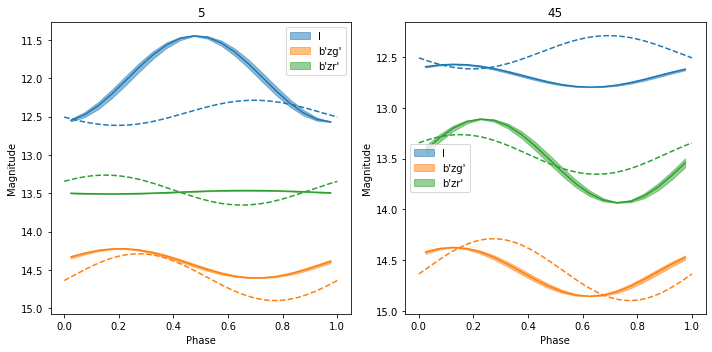

In [3]:
def plot_lightcurve(lightcurve_p,Kbf):    
    bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
    fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
    ax = np.reshape(ax,-1)
    for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
        for i,N in enumerate(bins):
            for f in pd.unique(lightcurve_p.index.get_level_values(2)):
                m = lightcurve_p.loc[(TYPE,N,f)]
                _=ax[i].plot(m.index,m['p_50'])[0].get_color()
                cut = Kbf[4]==f

                ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
                ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
            ax[i].legend()
            ax[i].set_xlabel('Phase')
            ax[i].set_ylabel('Magnitude')
            ax[i].set_title(N)
            ax[i].invert_yaxis()
    fig.tight_layout()
plot_lightcurve(Sim.lightcurve_p['fast'],Sim.best_fitting)

,p_16,p_50,p_84,max,min,sem,skewness,std
N,,,,,,,,
5,0.115009,0.115009,0.115009,0.115009,0.115009,2.789540e-18,1.0,1.249001e-16
10,3.272340,3.272340,3.272340,3.272340,3.272340,4.463264e-17,1.0,6.217249e-15
15,3.270199,3.270199,3.270199,3.270199,3.270199,4.463264e-17,1.0,2.220446e-15
20,3.270969,3.270969,3.270969,3.270969,3.270969,4.463264e-17,-1.0,2.220446e-15
25,3.270196,3.270196,3.270196,3.270196,3.270196,8.926529e-17,1.0,2.664535e-15
30,3.270421,3.270421,3.270421,3.270421,3.270421,1.785306e-16,-1.0,1.776357e-15
35,3.270329,3.270329,3.270329,3.270329,3.270329,4.463264e-17,1.0,4.884981e-15
40,3.270010,3.270010,3.270010,3.270010,3.270010,4.463264e-17,-1.0,4.440892e-16
45,3.270209,3.270209,3.270209,3.270209,3.270209,8.926529e-17,-1.0,1.332268e-15


No handles with labels found to put in legend.


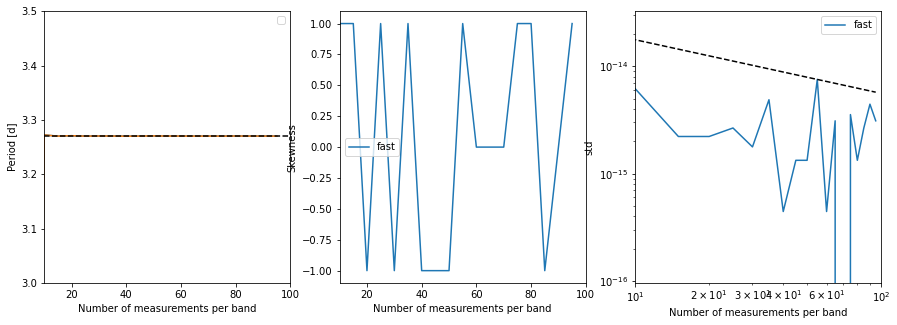

In [5]:
def periods(simulated_periods, P0,label,FIG=None):
    import scipy.stats as sc
    mean = simulated_periods.groupby(simulated_periods['N'],).median()
    p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
    p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
    p100 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.max(x.dropna(),))
    skewness  =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:sc.skew(x.dropna(),))
    std = simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.std(x.dropna(),))
    moments = {'P': [
                                                                                lambda x: np.percentile(x.dropna(),16),
                                                                                lambda x: np.percentile(x.dropna(),50),
                                                                                lambda x: np.percentile(x.dropna(),84),
                                                                                lambda x: np.max(x.dropna()),
                                                                                lambda x: np.min(x.dropna()),
                                                                                lambda x: sc.sem(x.dropna()),
                                                                                lambda x: sc.skew(x.dropna()),
                                                                                lambda x: np.std(x.dropna())]}
    moments = simulated_periods.groupby(simulated_periods['N'],).agg(moments)
    moments.columns = ['p_16', 'p_50', 'p_84','max','min','sem','skewness','std']
    display(moments)
    if FIG is None:
        fig,ax = plt.subplots(1,3,figsize=(15,5))
    else:
        fig,ax=FIG
    ax[0].plot(moments.index,moments.p_50)
    ax[0].plot(moments.index,moments['max'])
    ax[0].set_ylim(3,3.5)
    ax[0].fill_between(moments.index,moments.p_16,moments.p_84,alpha=0.5,color='C0')
    ax[0].axhline(P0,color='k',ls='dashed')
    
    ax[0].set_ylabel('Period [d]')
    ax[1].plot(moments.index,moments.skewness,label=label)
    
    ax[2].plot(moments.index,moments['std'],label=label)
    x = np.linspace(moments.index.min(),moments.index.max())
    xm = moments[moments['std']==moments['std'].max()].index.values[0]
    ax[2].set_xscale('log')
    ax[2].plot(x,moments['std'].max()*np.sqrt(xm/x),'k',ls='dashed')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('std')
    ax[1].set_ylabel('Skewness')
    for axx in ax:
        axx.set_xlim(10,100)
        axx.legend()
        axx.set_xlabel('Number of measurements per band')
    return fig,ax
FIG=periods(Sim.simulated_periods['fast'],3.27,'fast')
#FIG=periods(Sim.simulated_periods['slow'],3.27,'slow',FIG)

# Naive Multiband

In [ ]:
Naive\
    =np.vectorize(testing,signature="(),(),(),(),(),()->(),(),(a),(b,a),(b),(b,c),(b,c),()")(np.array([5*[i] for i in np.arange(5,200,5)]).flatten(),
                                                                                   3.27,data_+'testing_MC.csv',"naive", True,False)


#simulated_periods= pd.DataFrame({"N":MCN,"P":MCPeriods})
#lightcurve = pd.DataFrame()
#for _filter in pd.unique(MCFilter.flatten()):
#    
#    cut = MCFilter==_filter
#    phase =  MCPhase
#    for i,N in enumerate(pd.unique(MCN)):
#        
#        lightcurve=lightcurve.append(pd.DataFrame({"N":MCPhase.shape[-1]*[N], 
#                                                   "Filter":MCPhase.shape[-1]*[_filter], 
#                                                   "phase":MCPhase[cut][i], 
#                                                   "mag":MCMag[cut][i],"kind":MCType[i]}),ignore_index=True)
#lightcurve['phase bin'] = pd.cut(lightcurve.phase,20).apply(lambda x: x.mid)
#
#lightcurve_p = lightcurve.groupby(["kind",'N','Filter','phase bin',]).agg({'mag': [
#                                                                        lambda x: np.percentile(x,16),
#                                                                        lambda x: np.percentile(x,50),
#                                                                        lambda x: np.percentile(x,84)]})
#lightcurve_p.columns = ['p_16', 'p_50', 'p_84']
#
#lightcurve.to_csv('lightcurve_naive.csv')
#lightcurve_p.to_csv('lightcurve_p_naive.csv')

In [ ]:
bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
ax = np.reshape(ax,-1)
for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
    for i,N in enumerate(bins):
        for f in pd.unique(lightcurve_p.index.get_level_values(2)):
            m = lightcurve_p.loc[(TYPE,N,f)]
            _=ax[i].plot(m.index,m['p_50'])[0].get_color()
            cut = Kbf[4]==f
            
            ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
            ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
        ax[i].legend()
        ax[i].set_xlabel('Phase')
        ax[i].set_ylabel('Magnitude')
        ax[i].set_title(N)
        ax[i].invert_yaxis()
fig.tight_layout()

In [ ]:
mean = simulated_periods.groupby(simulated_periods['N'],).median()
p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
plt.plot(mean.index,mean.P)
plt.fill_between(mean.index,p16.P,p84.P,alpha=0.5,color='C0')
plt.xlim(10,100)
plt.axhline(P0,color='k',ls='dashed')
plt.xlabel('Number of measurements per band')
plt.ylabel('Period [d]')